## Asynchronous parallel processing of FVS keyfiles

In [2]:
import os
import glob
import subprocess
import ipyparallel as ipp
import shutil

A function to execute FVS that will be mapped to all keyfiles.

In [1]:
def run_fvs(keyfile):
    fvs_exe = 'C:\\FVSbin\\'+os.path.split(keyfile)[-1][:5]+'.exe'
    subprocess.call([fvs_exe, '--keywordfile='+keyfile]) # run fvs
    
    base_dir = os.path.split(keyfile)[0]
    base_name = os.path.split(keyfile)[-1].split('.')[0]
    
#     # clean-up the outputs
#     # move the .out and .key file
#     path = os.path.join(base_dir, 'completed','keyfiles')
#     if not os.path.exists(path): 
#         os.makedirs(path)
#     shutil.move(keyfile, os.path.join(base_dir,'completed','keyfiles'))
#     path = os.path.join(base_dir, 'completed','outfiles')
#     if not os.path.exists(path):
#         os.makedirs(path)
#     shutil.move(os.path.join(base_dir,base_name+'.out'), os.path.join(base_dir,'completed','outfiles'))
    
#     # delete the other files
#     os.remove(os.path.join(base_dir, base_name+'.trl'))
    return keyfile

Run the following command in a command prompt to start up a cluster of workers:

`>> activate Py3.5 # or other environment name`

`(Py3.5)>> ipcluster start -n 4 # or other number of cores`

In [3]:
# create a hub to control the workers
c = ipp.Client()
c.ids

[0, 1, 2, 3]

In [68]:
# if you want to run a single keyfile, use this
# subprocess.call(['C:\\FVSbin\\FVSpn.exe', '--keywordfile=C:\\GitHub\\FSC_Case_Studies\\keyfiles_to_run\\PN\\fvsPN_stand1_rx4_off0.key'])

# as another example, for serial (not parallel) processing of some keyfiles without cleaning up output files:
for keyfile in to_run:
    run_fvs(keyfile)
    #subprocess.call(['C:\\FVSbin\\FVSpn.exe', '--keywordfile='+keyfile])

Create a direct view of the workers and a load-balanced view for submitting jobs

In [4]:
dv = c[:] # direct view
v = c.load_balanced_view() # load-balanced view

# import packages to all workers
with dv.sync_imports():
    import subprocess
    import shutil
    import os

importing subprocess on engine(s)
importing shutil on engine(s)
importing os on engine(s)


Execute an ayschronous batch of FVS runs for all the keyfiles

In [27]:
# gather the list of keyfiles to run
run_dir = os.path.abspath('keyfiles_to_run')
to_run = glob.glob(os.path.join(run_dir, '*.key'))
print('{:,}'.format(len(to_run)), 'keyfiles found.')

46 keyfiles found.


In [28]:
to_run = to_run*15

Monitor progress of batch run

In [7]:
from tqdm import tqdm_notebook
import time

In [29]:
# start asynchronous batch with load-balanced view
res = v.map_async(run_fvs, to_run)
print('Started batch processing.')

runs_done = res.progress
with tqdm_notebook(total=len(res), initial=runs_done, desc='FVS Run Progress', unit='keyfile') as pbar:
    while not res.ready():
        new_progress = res.progress - runs_done
        runs_done += new_progress
        pbar.update(new_progress)
        time.sleep(0.5)

Started batch processing.


In [20]:
res.abort()

In [12]:
res.ready()

True

In [ ]:
# Return a true/false if full set of jobs completed
# res.ready()

# Cancels the batch (wait for fvs executables to complete)
# res.abort()

In [26]:
print('Human time spent:', res.wall_time)
print('Computer time spent:', res.serial_time)
print('Async speedup:', res.serial_time/res.wall_time)
print('Human time per FVS run:', res.wall_time/res.progress)
print('Computer time per FVS run:', res.serial_time/res.progress)

Human time spent: 4119.815965
Computer time spent: 16177.350972999937
Async speedup: 3.926716899598193
Human time per FVS run: 0.4017372954656265
Computer time per FVS run: 1.5775086273037482


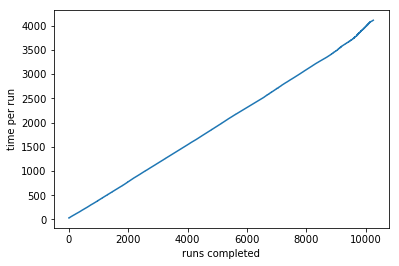

In [27]:
# inspect how processing speed per run changed as batch progressed
from matplotlib import pyplot as plt
%matplotlib inline
time_steps = 
#[(t2 - t1).total_seconds() for t2, t1 in zip(res.received, res.submitted)]
plt.plot(time_steps)
plt.ylabel('time per run')
plt.xlabel('runs completed')
plt.show()

In [29]:
len(glob.glob('C:/GitHub/FSC_Case_Studies/keyfiles_to_run/completed/keyfiles/*.key'))

61584

In [ ]:
len(stands)

In [37]:
# shut down the parallel workers
c.shutdown(hub=True)

### Check for runs that didn't complete successfully

In [69]:
import psycopg2
import pandas as pd
conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT keywordfile, caseid, mgmtid
FROM cases;
'''
# read the query into a pandas dataframe
completed = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [70]:
len(pd.unique(completed.caseid))

61584

In [71]:
len(completed.caseid)

61584

In [72]:
completed['keyfile'] = completed.keywordfile.apply(lambda x: os.path.split(x)[-1] + '.key')
completed.keyfile.values[0]

'fvsPN_stand10000_rx1_off0.key'

In [73]:
#counts = 
#counts.loc[counts.keyfile > 1]
cases_count = completed.groupby('caseid').count()
dupes = cases_count.loc[cases_count.keyfile > 1]
dupes

,keywordfile,mgmtid,keyfile
caseid,,,


In [74]:
completed_keys = glob.glob('C:\\GitHub\\FSC_Case_Studies\\keyfiles_to_run\\completed\\keyfiles\\*.key')
completed_basenames = [os.path.split(x)[-1] for x in completed_keys]
print(len(completed), 'keyfiles in database')
print(len(completed_basenames), 'keyfiles in completed folder')

for keyfile in completed.keyfile.values: # keyfiles recorded in the DB
    if keyfile not in completed_basenames:
        print(keyfile)

for keyfile in completed_basenames: # keyfiles recorded in the DB
    if keyfile not in completed.keyfile.values: # keyfiles moved into output folder
        print(keyfile)

61584 keyfiles in database
61584 keyfiles in completed folder


In [64]:
# to_rerun = ['fvsPN_stand11299_rx3_off0.key', 'fvsPN_stand1862_rx2inner_off0.key', 'fvsPN_stand2369_rx4_off0.key', 
#             'fvsPN_stand2369_rx5_off0.key', 'fvsPN_stand237_rx5_off0.key', 'fvsPN_stand239_rx3_off0.key', 
#             'fvsPN_stand319_rx5inner_off0.key', 'fvsPN_stand4225_rx1_off0.key', 'fvsPN_stand5802_rx5inner_off0.key',
#             'fvsPN_stand7307_rx3_off0.key']

# for keyfile in to_rerun:
# # move the keyfile back into the keyfiles_to_run directory
#     outfile = keyfile.split('.key')[0] + '.out'
#     base_dir = 'C:/GitHub/FSC_Case_Studies/keyfiles_to_run'
#     #shutil.move(os.path.join(base_dir,'completed','keyfiles', keyfile), os.path.join(base_dir,keyfile))
#     shutil.move(os.path.join(base_dir,'completed','outfiles', outfile), os.path.join(base_dir,outfile))
#     print('Moved', outfile, '.')

Moved fvsPN_stand11299_rx3_off0.out .
Moved fvsPN_stand1862_rx2inner_off0.out .
Moved fvsPN_stand2369_rx4_off0.out .
Moved fvsPN_stand2369_rx5_off0.out .
Moved fvsPN_stand237_rx5_off0.out .
Moved fvsPN_stand239_rx3_off0.out .
Moved fvsPN_stand319_rx5inner_off0.out .
Moved fvsPN_stand4225_rx1_off0.out .
Moved fvsPN_stand5802_rx5inner_off0.out .
Moved fvsPN_stand7307_rx3_off0.out .


In [49]:
counts = completed.groupby('keywordfile').count()
counts.loc[counts.keyfile > 1]

,caseid,mgmtid,keyfile
keywordfile,,,
C:\G...es\keyfiles_to_run\fvsPN_stand2369_rx4_off0,2,2,2
C:\G...es\keyfiles_to_run\fvsPN_stand2369_rx5_off0,2,2,2


In [75]:
conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT mgmtid, cases.caseid, cases.standid, keywordfile, total_stand_carbon, rbdft, summary.year
FROM cases, summary, carbon
WHERE cases.caseid = summary.caseid AND cases.caseid = carbon.caseid AND summary.year = carbon.year AND cases.standid = summary.standid AND cases.standid = carbon.standid;
'''
# read the query into a pandas dataframe
completed_attributes = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [76]:
completed_attributes.head()

,mgmtid,caseid,standid,keywordfile,total_stand_carbon,rbdft,year
0,Rx5,5660f58f-aa81-41aa-b39a-1c55fc4eb16f,10002,C:\G...s\keyfiles_to_run\fvsPN_stand10002_rx5_...,61.2331,0.0,2094
1,Rx3,52203654-5d20-4f94-b7ec-2ec3cf34f59e,10003,C:\G...s\keyfiles_to_run\fvsPN_stand10003_rx3_...,64.1227,0.0,2079
2,Rx1,509ae665-0b75-4e27-b3f6-19a78418ad2c,10004,C:\G...s\keyfiles_to_run\fvsPN_stand10004_rx1_...,108.6650,0.0,2019
3,Rx4,170309be-515b-459e-a231-fffb393475de,10004,C:\G...s\keyfiles_to_run\fvsPN_stand10004_rx4_...,62.8849,0.0,2054
4,Rx5,b1deaf0a-8148-4d41-902f-17998fbd1347,10004,C:\G...s\keyfiles_to_run\fvsPN_stand10004_rx5_...,88.6484,7393.0,2064


In [77]:
count_atts = completed_attributes.groupby(['mgmtid', 'standid']).count()

In [78]:
completed_attributes.loc[completed_attributes.year == 2014][['mgmtid', 'standid']].groupby(['mgmtid']).count()

,standid
mgmtid,
Rx1,10500
Rx2,10500
Rx2I,4020
Rx2O,522
Rx3,10500
Rx4,10500
Rx5,10500
Rx5I,4020
Rx5O,522


In [80]:
count_atts.loc[count_atts.rbdft != 20]

,,caseid,keywordfile,total_stand_carbon,rbdft,year
mgmtid,standid,,,,,


In [ ]:
# failed = glob.glob('C:\\GitHub\\FSC_Case_Studies\\keyfiles_to_run\\PN\\completed\\outfiles\\failed\\*.out')
# failed_basenames = [os.path.split(x)[-1].split('.')[0] for x in failed]
# moved = glob.glob('C:\\GitHub\\FSC_Case_Studies\\keyfiles_to_run\\*.key')
# moved_basenames = [os.path.split(x)[-1].split('.')[0] for x in moved]
# for path in moved:
#     if os.path.split(path)[-1].split('.')[0] not in failed_basenames:
#         print(path, "not in failed, but was moved")
# for path in failed:
#     if os.path.split(path)[-1].split('.')[0] not in moved_basenames:
#         print(path, "not in moved, but failed")